In [1]:
'''First, we need to define the path of where to get the dataset, and define other parameters that we will need'''
import sys
sys.path.append('/Users/jakehirst/Desktop/sfx/sfx_ML_code/sfx_ML/New_Models')

from Bagging_models import *
from ReCalibration import *
from Backward_feature_selection import *
import ast

model_types = {'bagging': ['ANN', 'RF', 'GPR','ridge'],
               'single': ['Single RF', 'Single GPR', 'NN_fed_GPR', 'NN_fed_RF', 'RF_fed_GPR']}

# model_types = {'bagging': ['ridge'],
#                'single': ['Single RF']}

all_labels = ['height', 'phi', 'theta',
                            'impact site x', 'impact site y', 'impact site z',
                            'impact site r', 'impact site phi', 'impact site theta']

num_models_list = [20]
labels_to_predict = ['impact site x', 'impact site y', 'height']
# labels_to_predict = ['impact site x']

with_or_without_transformations = 'with'
with_or_without_transformations = 'without'

Paper2_path = f'/Volumes/Jake_ssd/Paper 2/recalibrations/{with_or_without_transformations}_transformations'
if(not os.path.exists(Paper2_path)): os.makedirs(Paper2_path)
model_folder = Paper2_path + f'/UQ_bagging_models_{with_or_without_transformations}_transformations'
data_folder = Paper2_path + '/5fold_datasets'
results_folder = Paper2_path + '/Compare_Code_5_fold_ensemble_results'
# hyperparam_folder = Paper2_path + f'/bayesian_optimization_{with_or_without_transformations}_transformations'
Old_paper2_path = f'/Volumes/Jake_ssd/Paper 2/{with_or_without_transformations}_transformations'

hyperparam_folder = Old_paper2_path + f'/bayesian_optimization_{with_or_without_transformations}_transformations'



# image_folder = '/Users/jakehirst/Desktop/sfx/sfx_ML_data/images_sfx/new_dataset/Visible_cracks'
image_folder = ''

if(with_or_without_transformations == 'with'):
    full_dataset_pathname = "/Volumes/Jake_ssd/Paper 1/Paper_1_results_WITH_feature_engineering/dataset/feature_transformations_2023-11-16/height/HEIGHTALL_TRANSFORMED_FEATURES.csv"
    backward_feat_selection_results_folder = '/Volumes/Jake_ssd/Paper 1/Paper_1_results_WITH_feature_engineering/results'
else:
    # full_dataset_pathname = "/Volumes/Jake_ssd/Paper 1/Paper_1_results_no_feature_engineering/dataset/New_Crack_Len_FULL_OG_dataframe_2023_11_16.csv"
    full_dataset_pathname = "/Volumes/Jake_ssd/Paper 2/New_Crack_Len_FULL_OG_dataframe_2024_02_22.csv"
    backward_feat_selection_results_folder = Paper2_path + '/Paper_2_results_WITHOUT_feature_engineering/results'
    df = pd.read_csv(full_dataset_pathname, index_col=0)
    all_features = df.columns
    all_features = all_features.drop(all_labels)
    all_features = str(all_features.drop('timestep_init').to_list())

    print(all_features)



'''Only have to uncomment this if the 5 fold datasets have not been made or need to be remade'''
# make_5_fold_datasets(data_folder, full_dataset_pathname, image_folder)
# make_5_fold_datasets_with_calibration_set(data_folder, full_dataset_pathname, image_folder)


print('ALL_TRANSFORMED_FEATURES' in full_dataset_pathname)

forestci is an optional dependency. To install latest forestci compatabilty with scikit-learn>=0.24, run pip install git+git://github.com/scikit-learn-contrib/forest-confidence-interval.git
XGBoost is an optional dependency. If you want to use XGBoost models, please manually install xgboost package with pip install xgboost. If have error with finding libxgboost.dylib library, dobrew install libomp. If do not have brew on your system, first do ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)" from the Terminal
scikit-lego is an optional dependency, enabling use of the LowessRegression model. If you want to use this model, do "pip install scikit-lego"
['init z', 'init y', 'init x', 'max_prop_speed', 'avg_prop_speed', 'dist btw frts', 'crack len', 'linearity', 'max thickness', 'mean thickness', 'median_thickness', 'var_thickness', 'std_thickness', 'thickness_at_init', 'max_kink', 'abs_val_mean_kink', 'mean_kink', 'sum_kink', 'abs_val_sum_kink', 'med

In [2]:
'''get the appropriate features that each model will use based on backward feature elimination'''
all_features_to_keep = {}

min_features = 1 #minimum number of features you want to select from BFS (backward feature selection)
max_features = 25 #maximum number of features you want to select from BFS
for label in labels_to_predict:
    all_features_to_keep[label] = {}
    for model_type in model_types['bagging']:
        
        if('ALL_TRANSFORMED_FEATURES' in full_dataset_pathname):
            print('true')
        #TODO use code below if using feature selection
            best_features = get_best_features(backward_feat_selection_results_folder, label, model_type, min_features, max_features)
            all_features_to_keep[label][model_type] = best_features
        
        else:
            print('using just the basic features')
            #TODO use code below if NOT using feature selection
            all_features_to_keep[label][model_type] = all_features

print(all_features_to_keep)

using just the basic features
using just the basic features
using just the basic features
using just the basic features
using just the basic features
using just the basic features
using just the basic features
using just the basic features
using just the basic features
using just the basic features
using just the basic features
using just the basic features
{'impact site x': {'ANN': "['init z', 'init y', 'init x', 'max_prop_speed', 'avg_prop_speed', 'dist btw frts', 'crack len', 'linearity', 'max thickness', 'mean thickness', 'median_thickness', 'var_thickness', 'std_thickness', 'thickness_at_init', 'max_kink', 'abs_val_mean_kink', 'mean_kink', 'sum_kink', 'abs_val_sum_kink', 'median_kink', 'std_kink', 'var_kink', 'avg_ori', 'angle_btw']", 'RF': "['init z', 'init y', 'init x', 'max_prop_speed', 'avg_prop_speed', 'dist btw frts', 'crack len', 'linearity', 'max thickness', 'mean thickness', 'median_thickness', 'var_thickness', 'std_thickness', 'thickness_at_init', 'max_kink', 'abs_val_me

# Making all bagging models (GPR ensemble, ANN ensemble, etc.)

In [10]:
'''Now we will make all of the bagging models'''
for fold_no in range(1,6):
    for model_type in model_types['bagging']:
        for label_to_predict in labels_to_predict:
            for num_models in num_models_list:
                
                print(f'\n$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\ Predicting {label_to_predict} using {model_type} $$$$$$$$$$$$$$$$$$$$$$$$$$$$$\n')
                
                all_labels = ['height', 'phi', 'theta', 
                            'impact site x', 'impact site y', 'impact site z', 
                            'impact site r', 'impact site phi', 'impact site theta']

                print(f'{data_folder}/{label_to_predict}/fold{fold_no}/train_features.csv')
                training_features = pd.read_csv(f'{data_folder}/{label_to_predict}/fold{fold_no}/train_features.csv').reset_index(drop=True)
                training_labels = pd.read_csv(f'{data_folder}/{label_to_predict}/fold{fold_no}/train_labels.csv').reset_index(drop=True)

                model_saving_folder = f'{model_folder}/{label_to_predict}/{model_type}/uncalibrated/fold_{fold_no}'
                if(not os.path.exists(model_saving_folder)):
                    os.makedirs(model_saving_folder)
                    
                results_saving_folder = f'{results_folder}/{label_to_predict}/{model_type}/uncalibrated/fold_{fold_no}'
                if(not os.path.exists(results_saving_folder)):
                    os.makedirs(results_saving_folder)
                # make_dirs(model_saving_folder)
                # make_dirs(results_saving_folder)

                '''TODO gotta find out what features to use for each label before testing on new dataset'''
                features_to_keep = ast.literal_eval(all_features_to_keep[label_to_predict][model_type])
                print(features_to_keep)
                make_linear_regression_models_for_ensemble(training_features, training_labels, model_saving_folder, label_to_predict, num_models, features_to_keep, hyperparam_folder, model_type=model_type)


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\ Predicting impact site x using ANN $$$$$$$$$$$$$$$$$$$$$$$$$$$$$

/Volumes/Jake_ssd/Paper 2/recalibrations/without_transformations/5fold_datasets/impact site x/fold1/train_features.csv
['init z', 'init y', 'init x', 'max_prop_speed', 'avg_prop_speed', 'dist btw frts', 'crack len', 'linearity', 'max thickness', 'mean thickness', 'median_thickness', 'var_thickness', 'std_thickness', 'thickness_at_init', 'max_kink', 'abs_val_mean_kink', 'mean_kink', 'sum_kink', 'abs_val_sum_kink', 'median_kink', 'std_kink', 'var_kink', 'avg_ori', 'angle_btw']
working on model 0


# Evaluating bagging models and saving results.

In [ ]:
'''Now we will evaluate the performance of the bagging models'''


for model_type in model_types['bagging']:
    print(f'MODEL TYPE = {model_type}')
    for label_to_predict in labels_to_predict:
        print(f'LABEL = {label_to_predict}')
        for num_models in num_models_list:
            performance_data = []
            for fold_no in range(1,6):
                print(f'fold {fold_no}')

                #defining folders to get the models and to store the results
                model_saving_folder = f'{model_folder}/{label_to_predict}/{model_type}/uncalibrated/fold_{fold_no}'
                results_saving_folder = f'{results_folder}/{label_to_predict}/{model_type}/uncalibrated/fold_{fold_no}'
                
                #defining folders where the datasets are coming from (5-fold cv)
                test_features_path = Paper2_path + f'/5fold_datasets/{label_to_predict}/fold{fold_no}/test_features.csv'
                test_labels_path = Paper2_path + f'/5fold_datasets/{label_to_predict}/fold{fold_no}/test_labels.csv'
                train_features_path = Paper2_path + f'/5fold_datasets/{label_to_predict}/fold{fold_no}/train_features.csv'
                train_labels_path = Paper2_path + f'/5fold_datasets/{label_to_predict}/fold{fold_no}/train_labels.csv'

                #defining the features that each model used (since they vary with each model)
                features_to_keep = ast.literal_eval(all_features_to_keep[label_to_predict][model_type])
                
                #predicting the test and train sets with the bagging models
                test_r2, test_ensemble_predictions, test_ensemble_uncertanties, test_labels = Get_predictions_and_uncertainty_with_bagging(test_features_path, test_labels_path, model_saving_folder, results_saving_folder, features_to_keep, label_to_predict, model_type)
                train_r2, train_ensemble_predictions, train_ensemble_uncertanties, train_labels = Get_predictions_and_uncertainty_with_bagging(train_features_path, train_labels_path, model_saving_folder, results_saving_folder, features_to_keep, label_to_predict, model_type)

                #defining the residual errors of the predictions
                train_labels_arr = train_labels.to_numpy().T[0]
                train_predictions_arr = np.array(train_ensemble_predictions)
                test_labels_arr = test_labels.to_numpy().T[0]
                test_predictions_arr = np.array(test_ensemble_predictions)
                train_residuals = pd.Series(np.abs(train_labels_arr - train_predictions_arr))
                test_residuals = pd.Series(np.abs(test_labels_arr - test_predictions_arr))

                '''
                Calculating and plotting performance metrics as outlined in section 2.3 of Tran et al. (https://dx.doi.org/10.1088/2632-2153/ab7e1a)
                
                Models should be compared in terms of 
                1st - accuracy (R^2) 
                2nd - calibration (miscalibration area)
                3rd - sharpness
                4th - dispersion
                '''
                #CALIBRATION plots and miscalibration area
                #This tells us how 'honest' our uncertainty values are. A perfect calibration plot would mean for a given confidence interval in our prediction
                #(say 90%), we can expect with 90% certainty that the true value falls within that confidence interval.
                miscalibration_area, calibration_error = make_calibration_plots(model_type, test_predictions_arr, test_labels_arr, test_ensemble_uncertanties, results_saving_folder)
                stdevs = np.array(test_ensemble_uncertanties)/2 #right now, i multiply the stds by 2 to make it look better in parity plots... but this needs the raw std.
                sharpness, dispersion = plot_sharpness_curve(stdevs, results_saving_folder)


                '''using library from Palmer et al. to make an rve plot'''
                # train_intercept, train_slope, CAL_train_intercept, CAL_train_slope, train_intercept, test_slope, CAL_test_intercept, CAL_test_slope = make_RVE_plots(label_to_predict, model_type, test_ensemble_predictions, test_ensemble_uncertanties, test_labels, train_ensemble_predictions, train_ensemble_uncertanties, train_labels, results_saving_folder, num_bins=15)
                
                '''collecting the performance data from this model'''
                # performance_data.append([15, fold_no, train_r2, test_r2, a, b, train_intercept, train_slope, CAL_train_intercept, CAL_train_slope, train_intercept, test_slope, CAL_test_intercept, CAL_test_slope, miscalibration_area, calibration_error])
                performance_data.append([fold_no, train_r2, test_r2, miscalibration_area, calibration_error, sharpness, dispersion])

            # columns = ['num bins', 'fold_no', 'train R2', 'test R2',  'a', 'b', 'train_intercept', 'train_slope', 'CAL_train_intercept', 'CAL_train_slope', 'train_intercept', 'test_slope', 'CAL_test_intercept', 'CAL_test_slope', 'miscal_area', 'cal_error']
            columns = ['fold_no', 'train R2', 'test R2', 'miscal_area', 'cal_error', 'sharpness', 'dispersion']
            df = pd.DataFrame(columns=columns)
            for row in performance_data:
                df.loc[len(df)] = row
            average_row = df.mean()
            df = df.append(average_row, ignore_index=True)
                
            results_saving_folder = f'{results_folder}/{label_to_predict}/{model_type}/uncalibrated'
            if(not os.path.exists(results_saving_folder)): os.makedirs(results_saving_folder)
            df.to_csv(results_saving_folder + f'/{label_to_predict}_{model_type}_{num_models}results.csv', index=False)

MODEL TYPE = ANN
LABEL = impact site x
fold 1
Calibration error = 0.78
fold 2
Calibration error = 0.65
fold 3
Calibration error = 1.62
fold 4
Calibration error = 0.82
fold 5
Calibration error = 0.99
LABEL = impact site y
fold 1
Calibration error = 0.80
fold 2
Calibration error = 1.53
fold 3
Calibration error = 1.76
fold 4
Calibration error = 2.38
fold 5
Calibration error = 2.20
LABEL = height
fold 1
Calibration error = 4.05
fold 2
Calibration error = 3.74
fold 3
Calibration error = 3.76
fold 4
Calibration error = 4.83
fold 5
Calibration error = 4.42
MODEL TYPE = RF
LABEL = impact site x
fold 1
Calibration error = 2.81
fold 2
Calibration error = 4.03
fold 3
Calibration error = 3.48
fold 4
Calibration error = 3.13
fold 5
Calibration error = 3.50
LABEL = impact site y
fold 1
Calibration error = 3.74
fold 2
Calibration error = 4.13
fold 3
Calibration error = 4.11
fold 4
Calibration error = 4.93
fold 5
Calibration error = 4.98
LABEL = height
fold 1
Calibration error = 5.61
fold 2
Calibratio

# Now making all single models (RF fed GPR, Single RF, etc.)

In [ ]:
from NN_fed_GPR import *
from NN_fed_RF import *
from RF_fed_GPR import *
from Bagging_models import *
from Backward_feature_selection import *
import ast
Old_paper2_path = f'/Volumes/Jake_ssd/Paper 2/{with_or_without_transformations}_transformations'
# model_folder = Paper2_path + f'/UQ_bagging_models_{with_or_without_transformations}_transformations'
# data_folder = Paper2_path + '/5fold_datasets'
# results_folder = Paper2_path + '/Compare_Code_5_fold_ensemble_results'
hyperparam_folder = Old_paper2_path + f'/bayesian_optimization_{with_or_without_transformations}_transformations'


'''Now we will make all of the models'''
def make_UQ_model(training_features, training_labels, model_saving_folder, label_to_predict, num_models, features_to_keep, hyperparam_folder, num_training_points=False, model_type=None): 
    models = []
    training_features = training_features[features_to_keep]
    current_label = training_labels.columns[0]
    if(not os.path.exists(model_saving_folder)): os.mkdir(model_saving_folder)

    if(model_type == 'Single RF'):
        depth, features, samples_leaf, samples_split, estimators = get_best_hyperparameters_RF(label_to_predict=training_labels.columns[0], hyperparameter_folder=hyperparam_folder)
        model =  RandomForestRegressor(max_depth=depth, max_features=features, 
                                       min_samples_leaf = samples_leaf, min_samples_split = samples_split, n_estimators=estimators, random_state=42)
        model.fit(training_features, training_labels)
        
    elif(model_type == 'Single GPR'):
        c, length_scale, noise_level = get_best_hyperparameters_GPR(label_to_predict=training_labels.columns[0], hyperparameter_folder=hyperparam_folder)
        kernel = ConstantKernel(constant_value=c) * RBF(length_scale=length_scale) + WhiteKernel(noise_level=noise_level)
        model = GaussianProcessRegressor(kernel=kernel, random_state=0, n_restarts_optimizer=25)
        model.fit(training_features, training_labels)
        
    elif(model_type == 'NN_fed_GPR'):
        # c, length_scale, noise_level = get_best_hyperparameters_NN_fed_GPR(label_to_predict=training_labels.columns[0], hyperparameter_folder=hyperparam_folder)
        model = NN_fed_GPR()
        model.fit(training_features, training_labels, hyperparam_folder)

    elif(model_type == 'RF_fed_GPR'):
        # c, length_scale, noise_level = get_best_hyperparameters_NN_fed_GPR(label_to_predict=training_labels.columns[0], hyperparameter_folder=hyperparam_folder)
        model = RF_fed_GPR()
        model.fit(training_features, training_labels, hyperparam_folder)
        
    elif(model_type == 'NN_fed_RF'):
        # c, length_scale, noise_level = get_best_hyperparameters_NN_fed_GPR(label_to_predict=training_labels.columns[0], hyperparameter_folder=hyperparam_folder)
        model = NN_fed_RF()
        model.fit(training_features, training_labels, hyperparam_folder, num_optimization_tries=100, hyperparam_folder=f'/Volumes/Jake_ssd/Paper 2/without_transformations/optimized_hyperparams/NN_fed_RF/{current_label}')
        
    save_ensemble_model(model, 1, model_saving_folder) 
    
    return 


for fold_no in range(1,6):
    for model_type in model_types['single']:
        for label_to_predict in labels_to_predict:
            print(f'\n$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\ Predicting {label_to_predict} using {model_type} $$$$$$$$$$$$$$$$$$$$$$$$$$$$$\n')
            
            all_labels = ['height', 'phi', 'theta', 
                        'impact site x', 'impact site y', 'impact site z', 
                        'impact site r', 'impact site phi', 'impact site theta']

            print(f'{data_folder}/{label_to_predict}/fold{fold_no}/train_features.csv')
            training_features = pd.read_csv(f'{data_folder}/{label_to_predict}/fold{fold_no}/train_features.csv').reset_index(drop=True)
            training_labels = pd.read_csv(f'{data_folder}/{label_to_predict}/fold{fold_no}/train_labels.csv').reset_index(drop=True)

            model_saving_folder = f'{model_folder}/{label_to_predict}/{model_type}/uncalibrated/fold_{fold_no}'
            if(not os.path.exists(model_saving_folder)):
                os.makedirs(model_saving_folder)
                
            results_saving_folder = f'{results_folder}/{label_to_predict}/{model_type}/uncalibrated/fold_{fold_no}'
            if(not os.path.exists(results_saving_folder)):
                os.makedirs(results_saving_folder)
            # make_dirs(model_saving_folder)
            # make_dirs(results_saving_folder)

            '''TODO gotta find out what features to use for each label before testing on new dataset'''
            features_to_keep = ast.literal_eval(all_features_to_keep[label_to_predict]['ridge'])
            print(features_to_keep)
            make_UQ_model(training_features, training_labels, model_saving_folder, label_to_predict, 1, features_to_keep, hyperparam_folder, model_type=model_type)
            # make_linear_regress


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\ Predicting impact site x using Single RF $$$$$$$$$$$$$$$$$$$$$$$$$$$$$

/Volumes/Jake_ssd/Paper 2/recalibrations/without_transformations/5fold_datasets/impact site x/fold1/train_features.csv
['init z', 'init y', 'init x', 'max_prop_speed', 'avg_prop_speed', 'dist btw frts', 'crack len', 'linearity', 'max thickness', 'mean thickness', 'median_thickness', 'var_thickness', 'std_thickness', 'thickness_at_init', 'max_kink', 'abs_val_mean_kink', 'mean_kink', 'sum_kink', 'abs_val_sum_kink', 'median_kink', 'std_kink', 'var_kink', 'avg_ori', 'angle_btw']

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\ Predicting impact site y using Single RF $$$$$$$$$$$$$$$$$$$$$$$$$$$$$

/Volumes/Jake_ssd/Paper 2/recalibrations/without_transformations/5fold_datasets/impact site y/fold1/train_features.csv
['init z', 'init y', 'init x', 'max_prop_speed', 'avg_prop_speed', 'dist btw frts', 'crack len', 'linearity', 'max thickness', 'mean thickness', 'median_thickness', 'var_thickness', 'std_thickn

# Evaluating all single models

In [ ]:
'''
Helper function predicts the labels of the featureset given, and the uncertainty.
Also compares this to the true labels of the dataset.
'''


'''Now we will evaluate the performance of the bagging models'''

for model_type in model_types['single']:
    print(f'MODEL TYPE = {model_type}')
    for label_to_predict in labels_to_predict:
        print(f'LABEL = {label_to_predict}')
        performance_data = []
        for fold_no in range(1,6):
            print(f'fold {fold_no}')
            
            #defining folders to get the models and to store the results
            model_saving_folder = f'{model_folder}/{label_to_predict}/{model_type}/uncalibrated/fold_{fold_no}'
            results_saving_folder = f'{results_folder}/{label_to_predict}/{model_type}/uncalibrated/fold_{fold_no}'
            
            #defining folders where the datasets are coming from (5-fold cv)
            test_features_path = Paper2_path + f'/5fold_datasets/{label_to_predict}/fold{fold_no}/test_features.csv'
            test_labels_path = Paper2_path + f'/5fold_datasets/{label_to_predict}/fold{fold_no}/test_labels.csv'
            train_features_path = Paper2_path + f'/5fold_datasets/{label_to_predict}/fold{fold_no}/train_features.csv'
            train_labels_path = Paper2_path + f'/5fold_datasets/{label_to_predict}/fold{fold_no}/train_labels.csv'

            #defining the features that each model used (since they vary with each model)
            features_to_keep = ast.literal_eval(all_features_to_keep[label_to_predict]['ridge'])
            
            #predicting the test and train sets with the bagging models
            test_r2, test_ensemble_predictions, test_ensemble_uncertanties, test_labels = Get_predictions_and_uncertainty_single_model(test_features_path, test_labels_path, model_saving_folder, results_saving_folder, features_to_keep, label_to_predict, model_type)
            train_r2, train_ensemble_predictions, train_ensemble_uncertanties, train_labels = Get_predictions_and_uncertainty_single_model(train_features_path, train_labels_path, model_saving_folder, results_saving_folder, features_to_keep, label_to_predict, model_type)

            #defining the residual errors of the predictions
            train_labels_arr = train_labels.to_numpy().T[0]
            train_predictions_arr = np.array(train_ensemble_predictions)
            test_labels_arr = test_labels.to_numpy().T[0]
            test_predictions_arr = np.array(test_ensemble_predictions)
            train_residuals = pd.Series(np.abs(train_labels_arr - train_predictions_arr))
            test_residuals = pd.Series(np.abs(test_labels_arr - test_predictions_arr))

            '''
            Calculating and plotting performance metrics as outlined in section 2.3 of Tran et al. (https://dx.doi.org/10.1088/2632-2153/ab7e1a)
            
            Models should be compared in terms of 
            1st - accuracy (R^2) 
            2nd - calibration (miscalibration area)
            3rd - sharpness
            4th - dispersion
            '''
            #CALIBRATION plots and miscalibration area
            #This tells us how 'honest' our uncertainty values are. A perfect calibration plot would mean for a given confidence interval in our prediction
            #(say 90%), we can expect with 90% certainty that the true value falls within that confidence interval.
            miscalibration_area, calibration_error = make_calibration_plots(model_type, test_predictions_arr, test_labels_arr, test_ensemble_uncertanties, results_saving_folder)
            #SHARPNESS plots and value
            #Models can be calibrated, but all have very dull uncertainty values (they all have large uncertainties). To ensure UQ is meaningful, models
            #should a be sharp (i.e. uncertainties should be as small as possible.)
            #Sharpness is essentially calculated as the average of predicted standard deviations. #COMMENT Low sharpness values are better.
            stdevs = np.array(test_ensemble_uncertanties)/2 #right now, i multiply the stds by 2 to make it look better in parity plots... but this needs the raw std.
            sharpness, dispersion = plot_sharpness_curve(stdevs, results_saving_folder)
            #DISPERSION value
            #Models can be calibrated and sharp, but even so, if they are all similar uncertainties, then this does not tell us much. To ensure more 
            #meaningful UQ, having a large dispersion of uncertainties is valuable. 
            #Dispersion is calculated using equation 4 of the paper, which is called the coefficient of variation (Cv). #COMMENT High dispersion (Cv) values are better.
                
            

            '''using their library to make an rve plot'''
            # train_intercept, train_slope, CAL_train_intercept, CAL_train_slope, train_intercept, test_slope, CAL_test_intercept, CAL_test_slope = make_RVE_plots(label_to_predict, model_type, test_ensemble_predictions, test_ensemble_uncertanties, test_labels, train_ensemble_predictions, train_ensemble_uncertanties, train_labels, results_saving_folder, num_bins=15)
            
            '''collecting the performance data from this model'''
            # performance_data.append([15, fold_no, train_r2, test_r2, a, b, train_intercept, train_slope, CAL_train_intercept, CAL_train_slope, train_intercept, test_slope, CAL_test_intercept, CAL_test_slope, miscalibration_area, calibration_error])
            performance_data.append([fold_no, train_r2, test_r2, miscalibration_area, calibration_error, sharpness, dispersion])
            
        # columns = ['num bins', 'fold_no', 'train R2', 'test R2',  'a', 'b', 'train_intercept', 'train_slope', 'CAL_train_intercept', 'CAL_train_slope', 'train_intercept', 'test_slope', 'CAL_test_intercept', 'CAL_test_slope', 'miscal_area', 'cal_error']
        columns = ['fold_no', 'train R2', 'test R2', 'miscal_area', 'cal_error', 'sharpness', 'dispersion']
        df = pd.DataFrame(columns=columns)
        for row in performance_data:
            df.loc[len(df)] = row
        average_row = df.mean()
        df = df.append(average_row, ignore_index=True)
            
        results_saving_folder = f'{results_folder}/{label_to_predict}/{model_type}/uncalibrated'
        if(not os.path.exists(results_saving_folder)): os.makedirs(results_saving_folder)
        df.to_csv(results_saving_folder + f'/{label_to_predict}_{model_type}_1results.csv', index=False)

MODEL TYPE = Single RF
LABEL = impact site x
fold 1
Calibration error = 0.24
fold 2
Calibration error = 0.23
fold 3
Calibration error = 0.09
fold 4
Calibration error = 0.49
fold 5
Calibration error = 0.07
LABEL = impact site y
fold 1
Calibration error = 0.23
fold 2
Calibration error = 0.13
fold 3
Calibration error = 0.07
fold 4
Calibration error = 0.75
fold 5
Calibration error = 0.43
LABEL = height
fold 1
Calibration error = 1.03
fold 2
Calibration error = 0.57
fold 3
Calibration error = 0.88
fold 4
Calibration error = 0.43
fold 5
Calibration error = 0.72
MODEL TYPE = Single GPR
LABEL = impact site x
fold 1
Calibration error = 0.22
fold 2
Calibration error = 0.19
fold 3
Calibration error = 0.39
fold 4
Calibration error = 0.55
fold 5
Calibration error = 0.37
LABEL = impact site y
fold 1
Calibration error = 0.19
fold 2
Calibration error = 0.03
fold 3
Calibration error = 0.22
fold 4
Calibration error = 0.31
fold 5
Calibration error = 0.23
LABEL = height
fold 1
Calibration error = 0.09
fol

# Recalibrating all models

In [3]:

all_improved = 0
total = 0

for bag_vs_single in model_types:
    print(bag_vs_single)
    for model_type in model_types[bag_vs_single]:
        print(f'MODEL_TYPE = {model_type}')
        for label_to_predict in labels_to_predict:
            results_saving_folder = f'{results_folder}/{label_to_predict}/{model_type}/calibrated'
            if(not os.path.exists(results_saving_folder)): os.makedirs(results_saving_folder)
            print(f'LABEL = {label_to_predict}')
            calibrated_performance_data = []
            for fold_no in range(1,6):            
                calibrated_results_path = f'{results_folder}/{label_to_predict}/{model_type}/calibrated'
                if(not os.path.exists(calibrated_results_path)): os.makedirs(calibrated_results_path)
                
                #defining folders to get the models and to store the results
                model_saving_folder = f'{model_folder}/{label_to_predict}/{model_type}/uncalibrated/fold_{fold_no}'
                results_saving_folder = f'{results_folder}/{label_to_predict}/{model_type}/uncalibrated/fold_{fold_no}'

                #defining folders where the datasets are coming from (5-fold cv)
                test_features_path = Paper2_path + f'/5fold_datasets/{label_to_predict}/fold{fold_no}/test_features.csv'
                test_labels_path = Paper2_path + f'/5fold_datasets/{label_to_predict}/fold{fold_no}/test_labels.csv'
                calibration_features_path = Paper2_path + f'/5fold_datasets/{label_to_predict}/fold{fold_no}/calibration_features.csv'
                calibration_labels_path = Paper2_path + f'/5fold_datasets/{label_to_predict}/fold{fold_no}/calibration_labels.csv'
                
                
                #predicting the test and train sets with the bagging models
                if(model_type in ['ANN', 'RF', 'GPR','ridge']):
                    test_r2, test_ensemble_predictions, test_uncertanties, test_labels = Get_predictions_and_uncertainty_with_bagging(test_features_path, test_labels_path, model_saving_folder, results_saving_folder, ast.literal_eval(all_features), label_to_predict, model_type)
                    cal_r2, cal_set_predictions, cal_set_uncertanties, cal_set_labels = Get_predictions_and_uncertainty_with_bagging(calibration_features_path, calibration_labels_path, model_saving_folder, results_saving_folder, ast.literal_eval(all_features), label_to_predict, model_type)
                else:
                    test_r2, test_ensemble_predictions, test_uncertanties, test_labels = Get_predictions_and_uncertainty_single_model(test_features_path, test_labels_path, model_saving_folder, results_saving_folder, ast.literal_eval(all_features), label_to_predict, model_type)
                    cal_r2, cal_set_predictions, cal_set_uncertanties, cal_set_labels = Get_predictions_and_uncertainty_single_model(calibration_features_path, calibration_labels_path, model_saving_folder, results_saving_folder, ast.literal_eval(all_features), label_to_predict, model_type)
                
                new_cal_uncertainties, recalibration_model = train_isotonic_model_and_adjust_uncertainties(cal_set_predictions, cal_set_uncertanties, cal_set_labels.to_numpy().flatten())
                
                old_miscal_area_cal_set, old_cal_error_cal_set = make_calibration_plots(model_type, np.array(cal_set_predictions), np.array(cal_set_labels), cal_set_uncertanties, '', show=2)
                new_miscal_area_cal_set, new_cal_error_cal_set = make_calibration_plots(model_type, np.array(cal_set_predictions), np.array(cal_set_labels), new_cal_uncertainties, '', show=2)
                improved = old_miscal_area_cal_set > new_miscal_area_cal_set
                if(improved):
                    all_improved +=1
                    total +=1 
                else:
                    total += 1
                print(f'percentage improved = {all_improved / total}')

                
                calibrated_test_uncertainties = use_isotonic_model_to_adjust_uncertainties(test_uncertanties, recalibration_model, test_ensemble_predictions, test_labels.to_numpy().flatten())
                
                if(not os.path.exists(results_saving_folder.replace('uncalibrated', 'calibrated'))): os.makedirs(results_saving_folder.replace('uncalibrated', 'calibrated'))
                #CALIBRATION plots and miscalibration area
                #This tells us how 'honest' our uncertainty values are. A perfect calibration plot would mean for a given confidence interval in our prediction
                #(say 90%), we can expect with 90% certainty that the true value falls within that confidence interval.
                new_miscalibration_area, new_calibration_error = make_calibration_plots(model_type, np.array(test_ensemble_predictions), np.array(test_labels), calibrated_test_uncertainties, results_saving_folder.replace('uncalibrated', 'calibrated'))
                #SHARPNESS plots and value
                #Models can be calibrated, but all have very dull uncertainty values (they all have large uncertainties). To ensure UQ is meaningful, models
                #should a be sharp (i.e. uncertainties should be as small as possible.)
                #Sharpness is essentially calculated as the average of predicted standard deviations. #COMMENT Low sharpness values are better.
                stdevs = np.array(calibrated_test_uncertainties)/2 #right now, i multiply the stds by 2 to make it look better in parity plots... but this needs the raw std.
                new_sharpness, new_dispersion = plot_sharpness_curve(stdevs, results_saving_folder.replace('uncalibrated', 'calibrated'))
                #DISPERSION value
                #Models can be calibrated and sharp, but even so, if they are all similar uncertainties, then this does not tell us much. To ensure more 
                #meaningful UQ, having a large dispersion of uncertainties is valuable. 
                #Dispersion is calculated using equation 4 of the paper, which is called the coefficient of variation (Cv). #COMMENT High dispersion (Cv) values are better.
                

                
                calibrated_performance_data.append([fold_no, cal_r2, test_r2, new_miscalibration_area, new_calibration_error, new_sharpness, new_dispersion])
                
            columns = ['fold_no', 'cal R2', 'test R2', 'miscal_area', 'cal_error', 'sharpness', 'dispersion']
            df = pd.DataFrame(columns=columns)
            for row in calibrated_performance_data:
                df.loc[len(df)] = row
            average_row = df.mean()
            df = df.append(average_row, ignore_index=True)
                

            df.to_csv(calibrated_results_path + f'/{label_to_predict}_{model_type}_calibrated_results.csv', index=False)


print(f'percentage improved = {all_improved / total}')


bagging
MODEL_TYPE = ANN
LABEL = impact site x


Calibration error = 1.00
Calibration error = 1.11
percentage improved = 0.0
Calibration error = 0.85
Calibration error = 2.13
Calibration error = 0.94
percentage improved = 0.5
Calibration error = 0.37
Calibration error = 1.34
Calibration error = 1.03
percentage improved = 0.6666666666666666
Calibration error = 0.27
Calibration error = 0.63
Calibration error = 0.62
percentage improved = 0.75
Calibration error = 0.71
Calibration error = 0.73
Calibration error = 0.92
percentage improved = 0.6
Calibration error = 0.32
LABEL = impact site y
Calibration error = 0.53
Calibration error = 0.64
percentage improved = 0.5
Calibration error = 0.48
Calibration error = 1.50
Calibration error = 0.38
percentage improved = 0.5714285714285714
Calibration error = 0.30
Calibration error = 2.56
Calibration error = 0.55
percentage improved = 0.625
Calibration error = 0.48
Calibration error = 1.91
Calibration error = 0.47
percentage improved = 0.6666666666666666
Calibration error = 0.74
Calibration error = 1

# Compare calibrated vs uncalibrated results

[0.0825175326403762, 0.1628383838383838, 0.2151761363636363, 0.1579289772727273, 0.0375768607547015, 0.0478014297325867, 0.0531818702323331, 0.0720105088396244, 0.0476961663355229]
['ANN', 'RF', 'GPR', 'ridge', 'Single RF', 'Single GPR', 'NN_fed_GPR', 'NN_fed_RF', 'RF_fed_GPR']


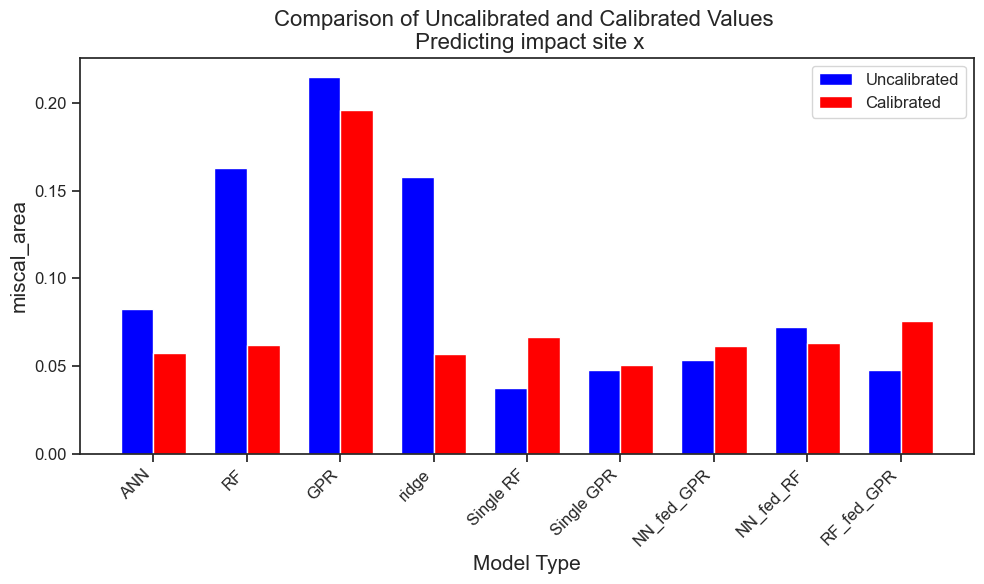

[0.1133499249406507, 0.1834090909090909, 0.200140533625731, 0.1605909090909091, 0.0451106703307287, 0.0342492828589563, 0.0384612323121655, 0.0743289829581253, 0.0556371091691318]
['ANN', 'RF', 'GPR', 'ridge', 'Single RF', 'Single GPR', 'NN_fed_GPR', 'NN_fed_RF', 'RF_fed_GPR']


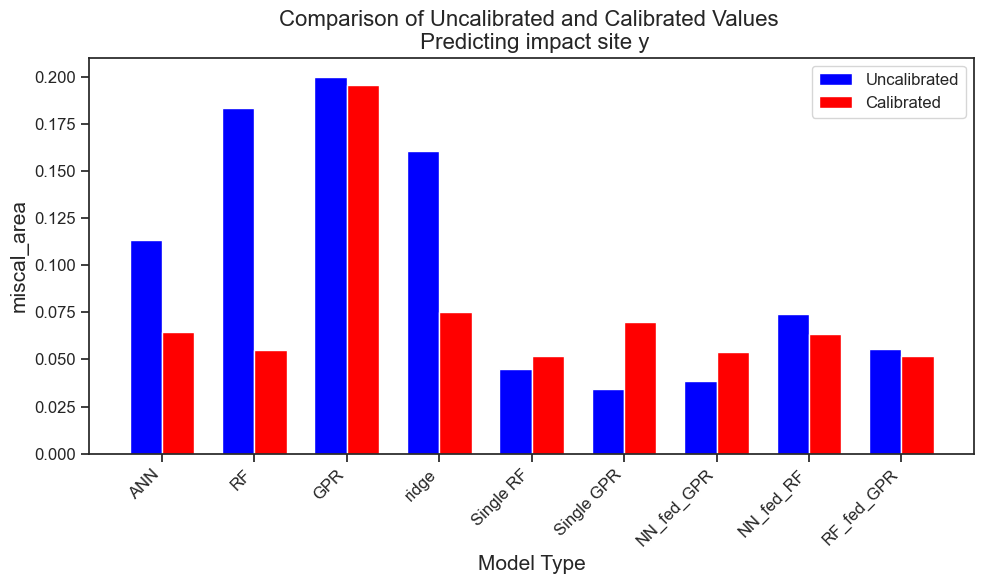

[0.1795271464646465, 0.1934876893939394, 0.2506360479797979, 0.1816530934343434, 0.0715918872711024, 0.0402277283003431, 0.0399705957988226, 0.2003873106060606, 0.0991276145525394]
['ANN', 'RF', 'GPR', 'ridge', 'Single RF', 'Single GPR', 'NN_fed_GPR', 'NN_fed_RF', 'RF_fed_GPR']


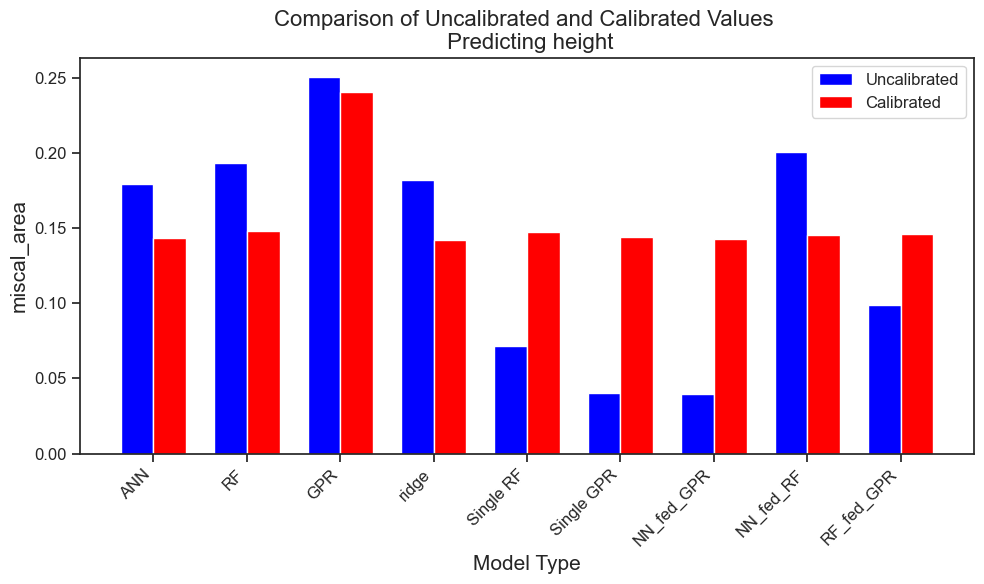

In [7]:
metric = 'miscal_area'
# metric = 'cal_error'
# metric = 'sharpness'
# metric = 'dispersion'



for label_to_predict in labels_to_predict:
    cal_values = {}
    uncal_values = {}
    for bag_vs_single in model_types:
        for model_type in model_types[bag_vs_single]:
            
            uncalibrated_folder = results_folder + f'/{label_to_predict}/{model_type}/uncalibrated'
            calibrated_folder = results_folder + f'/{label_to_predict}/{model_type}/calibrated'
            
            uncalibrated_csv = pd.read_csv(glob.glob(os.path.join(uncalibrated_folder, '**/*.csv'), recursive=True)[0])
            calibrated_csv = pd.read_csv(glob.glob(os.path.join(calibrated_folder, '**/*.csv'), recursive=True)[0])
            
            uncal_value = uncalibrated_csv.iloc[len(uncalibrated_csv)-1][metric]
            cal_value = calibrated_csv.iloc[len(calibrated_csv)-1][metric]

            uncal_values[model_type] = uncal_value
            cal_values[model_type] = cal_value
            
    # Setting up the figure and axis for the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Setting the positions of the bars on the x-axis
    indices = range(len(uncal_values))

    # Width of the bars
    bar_width = 0.35
    print(list(uncal_values.values()))
    # Plotting both uncalibrated and calibrated values
    ax.bar(indices, list(uncal_values.values()), bar_width, label='Uncalibrated', color='blue')
    ax.bar([i + bar_width for i in indices], list(cal_values.values()), bar_width, label='Calibrated', color='red')

    # Adding the aesthetics
    ax.set_xlabel('Model Type', fontsize=15)
    ax.set_ylabel(metric, fontsize=15)
    ax.set_title(f'Comparison of Uncalibrated and Calibrated Values \n Predicting {label_to_predict}', fontsize=16)
    ax.set_xticks([i + bar_width / 2 for i in indices])
    x_labels = list(uncal_values.keys())
    print(x_labels)
    ax.set_xticklabels(x_labels, rotation=45, ha="right")

    # Adding the legend
    ax.legend()

    # Showing the plot
    plt.tight_layout()
    plt.show()
    

            
            
            


                